In [18]:
import numpy as np
import pyromat as pm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve # Import the solver

#==== (Your setup code remains the same) ====
pm.config["unit_pressure"] = "kPa"
pm.config["unit_temperature"] = "K"
pm.config["unit_energy"] = "kJ"
air = pm.get("ig.air")
R_air = air.R()

This is an integrator to find the effects of heat transfer on the efficiency of an average internal combustion engine.

We will start by defining our knowns (lots of engine dimensions that can vary the results widely)

In [19]:
#=== Known Thermo Values ===
P1=95           #Initial pressure (kPa)
T1=320          #Initial temperature (K)
h=0.3           #Heat transfer coefficient (kJ/s*kg*K)

# =================================================================================
# ======================== ENGINE SPECIFICATION LIBRARY ===========================
# =================================================================================
#
# --- GM LS7 (7.0L V8) ---
# Bore:    0.1048 m
# Stroke:  0.1016 m
# Rod Len: 0.1541 m (6.067 in)
# Comp R:  11.0
# Source:  Summit Racing (https://help.summitracing.com/knowledgebase/article/SR-04882/en-us)
#              Wikipedia (https://en.wikipedia.org/wiki/General_Motors_LS-based_small-block_engine)
#
# --- Honda K20C1 (2.0L Turbo I4) ---
# Bore:    0.086 m
# Stroke:  0.0859 m (Note: This is a square engine, sometimes listed as 93.0mm stroke for other K20 variants)
# Rod Len: 0.149 m
# Comp R:  9.8
# Source:  Engine Builder Magazine (https://www.enginebuildermag.com/2020/01/the-honda-k20c1-engine-a-technical-deep-dive/)
#                        Wikipedia (https://en.wikipedia.org/wiki/Honda_K_engine)
#
# --- Mazda Skyactiv-G (2.5L I4) ---
# Bore:    0.89 m
# Stroke:  0.100 m
# Rod Len: 0.1545 m
# Comp R:  13.0 (US Spec)
# Source:  Mazda6 Revolution Forum (https://www.mazda6-forum.com/threads/skyactiv-2-5-specs-thread.399562/)
#                        Wikipedia (https://en.wikipedia.org/wiki/Skyactiv)


#=== Known Engine Values ===
B=      0.1048          #Bore diameter (m)
S=      0.1016          #Sweep distance (m)
l=      0.1541          #Connecting rod length (m)
rc=     11.0            #Compression ratio

T_block=450             #Temperature of the engine block (K)
T_comb= 2500            #Temperature at state 3 (K)
rpm = 300               #Engine speed (rpm)

r=S/2                       #Crank radius (m)
freq=rpm*2*np.pi/60         #Engine speed (rad/s)
V_s = (np.pi/4) * B**2 * S  #Swept volume (m^3)
V_c = V_s / (rc - 1)        #clearance volume (m^3)


Many of these initial conditions are sourced from wikipedia / google and can be messed with to increase situational accuracy.

Now we will define the volume of the cylinder as a function of time.

This is the position over time
$$x(t) = r\cos(\theta)+\sqrt{l^2-(r\sin(\theta))^2}$$
Assuming a regular cylinder, the area of the face is:
$$A_{face}=\frac{B^2\pi}{4}$$
Which we will assume is equal to both the cylinder head and piston face.
Combining $x(t)$ and $A_{face}$, and substituting the identity $\theta = \omega t$:

$$V(t)= V_c + \frac{B^2\pi}{4}\left(l+r-\sqrt{l^2-(r\sin(\omega t))^2}-r\cos(\omega t)\right)$$



In [20]:
def V(t):                   #Volume over time
    theta = freq*t
    return V_c + (V_s/2)*(1 - np.cos(theta) + (l/r) - np.sqrt((l/r)**2 - np.sin(theta)**2))

We will need the derivative of this function to calculate work:

$$\frac{dV}{dt}(t)=\frac{B^2\pi}{4}\left(\frac{r^2\omega\sin(\omega t)\cos(\omega t)}{\sqrt{l^2-(r\sin(\omega*t))^2}}+r\omega\sin(\omega t)\right)$$

In [21]:
def dVdt(t):                #Rate of change of volume over time
    theta = freq*t
    term1 = np.sin(theta)
    term2 = np.cos(theta) * np.sin(theta) / np.sqrt((l/r)**2 - np.sin(theta)**2)
    return (V_s/2) * freq * (term1 + term2)

Now we can find some more initial values:

In [22]:
V1 = V(-np.pi/freq)             #Initial Volume
m = (P1 * V1) / (R_air * T1)    #Mass of air
print(f"Calculated initial volume: {V1:.4f} m^3")
print(f"Calculated consistent mass of air: {m*1000:.4f} grams")

Calculated initial volume: 0.0010 m^3
Calculated consistent mass of air: 0.9970 grams


For the heat transfer side of things, we need to calculate the area of the engine exposed to the WF as a function of time:

$$A(t) = 2A_{face} + (l+r-x(t))\cdot B\pi$$

In [23]:
def A(t):
    theta = freq*t
    piston_pos = r*np.cos(theta) + np.sqrt(l**2 - (r*np.sin(theta))**2)
    exposed_height = l + r - piston_pos
    return (np.pi/2)*B**2 + np.pi*B*exposed_height

This is enough to set up our ODE. We want to find the temperature inside the cylinder as a function of time. To do that we will use an integrator and these functions:
$$\tilde v(t) = V(t)/m$$
We will use PyroMat to find the properties of ideal air at given state points;
$$P_i = P(T_{i-1}, \tilde v)$$
$$c_V = c_V(T_{i-1})$$
$$\dot W = P_i\cdot\frac{dV}{dt}(t)$$
$$\dot Q = h\cdot A(t)\cdot (T_{block} - T_{i-1})$$

Then using the first law of thermodynamics:
$$m\cdot c_V\cdot T = Q- W$$
Taking the derivative with respect to time and isolating T:
$$dT_i=\frac{\dot Q-\dot W}{m\cdot c_V}$$

In [24]:
def otto_model(t, y):
    T = y[0]
    current_volume = V(t)
    current_spec_vol = current_volume / m
    P = air.p(T=T, v=current_spec_vol)[0]
    cv = air.cv(T=T)[0]
    W_dot = P * dVdt(t)
    Q_dot_ht = h * A(t) * (T_block - T)
    dTdt = (Q_dot_ht - W_dot) / (m * cv)
    return [dTdt]

Now we can start solving the initial value problem for the compression stroke

In [25]:
# === Time Intervals & Initial Conditions ===
t_start_comp = -np.pi / freq
t_end_comp = 0
y0_comp = [T1]

# === Solve for the Compression Stroke ===
sol_comp = solve_ivp(
    otto_model, [t_start_comp, t_end_comp], y0_comp, dense_output=True, max_step=1e-5
)

We can now fix the initial conditions for the power stroke and solve for the rest of the process.

In [26]:
y0_power = [T_comb] # Use the calculated temperature
t_start_power = 0
t_end_power = np.pi/freq

# === Solve for the Power Stroke ===
sol_power = solve_ivp(
    otto_model, [t_start_power, t_end_power], y0_power, dense_output=True, max_step=1e-5
)

For better comparisons, we'll now solve the standard isentropic Otto cycle

In [27]:
t_plot_comp = np.linspace(t_start_comp, t_end_comp, 200)        #time discretization
t_plot_power = np.linspace(t_start_power, t_end_power, 200)

V1 = V(t_start_comp)
s1= air.s(T=T1, v = V1/m)[0]
v_spec_comp_curve = V(t_plot_comp)/m

V3 = V(t_start_power)
s3 = air.s(T=T_comb, v= V3/m)[0]
v_spec_power_curve = V(t_plot_power)/m

Now to get all the plottable points inbetween the states:

In [28]:
T_plot_comp_ht = sol_comp.sol(t_plot_comp)[0]
T_plot_power_ht = sol_power.sol(t_plot_power)[0]
P_plot_comp_ht = air.p(T=T_plot_comp_ht, v=v_spec_comp_curve)
P_plot_power_ht = air.p(T=T_plot_power_ht, v=v_spec_power_curve)

T_plot_comp_isentropic = air.T(s=s1, v=v_spec_comp_curve)
T_plot_power_isentropic = air.T(s=s3, v=v_spec_power_curve)
P_plot_comp_isentropic = air.p(T=T_plot_comp_isentropic, v=v_spec_comp_curve)
P_plot_power_isentropic = air.p(T=T_plot_power_isentropic, v=v_spec_power_curve)

We need to determine the $q_{in}$ for efficiency calculations.

To do this we will use the identity:
$$q = u_f-u_i$$

In [29]:
T2_ht = T_plot_comp_ht[-1]
u2_ht = air.e(T=T2_ht)[0]

T2_isentropic = T_plot_comp_isentropic[-1]
u2_isentropic = air.e(T=T2_isentropic)[0]

u3 = air.e(T=T_comb)[0]

q_in_ht = u3-u2_ht
q_in_isentropic = u3-u2_isentropic

Using these we can integrate for work using the trapezoidal method.

In [30]:
P_total_ht = np.concatenate((P_plot_comp_ht,P_plot_power_ht))
P_avg_ht = (P_total_ht[:-1]+P_total_ht[1:])/2

P_total_isentropic = np.concatenate((P_plot_comp_isentropic,P_plot_power_isentropic))
P_avg_isentropic = (P_total_isentropic[:-1]+P_total_isentropic[1:])/2

v_total = np.concatenate((v_spec_comp_curve,v_spec_power_curve))
dv_total = np.diff(v_total)

w_net_ht = np.sum(P_avg_ht*dv_total)
w_net_isentropic = np.sum(P_avg_isentropic*dv_total)

eta_ht = w_net_ht/q_in_ht
eta_isentropic = w_net_isentropic/q_in_isentropic
diff=np.abs(eta_ht-eta_isentropic)

print(f"Calculated efficiency for standard model: {eta_isentropic*100:.3f}% \nCalculated efficiency for heat transfer model: {eta_ht*100:.3f}%\nDifference: {diff*100:.3f}%")

Calculated efficiency for standard model: 54.996% 
Calculated efficiency for heat transfer model: 42.294%
Difference: 12.701%


Now we can do all the pretty plots! Heres a T-t diagram:

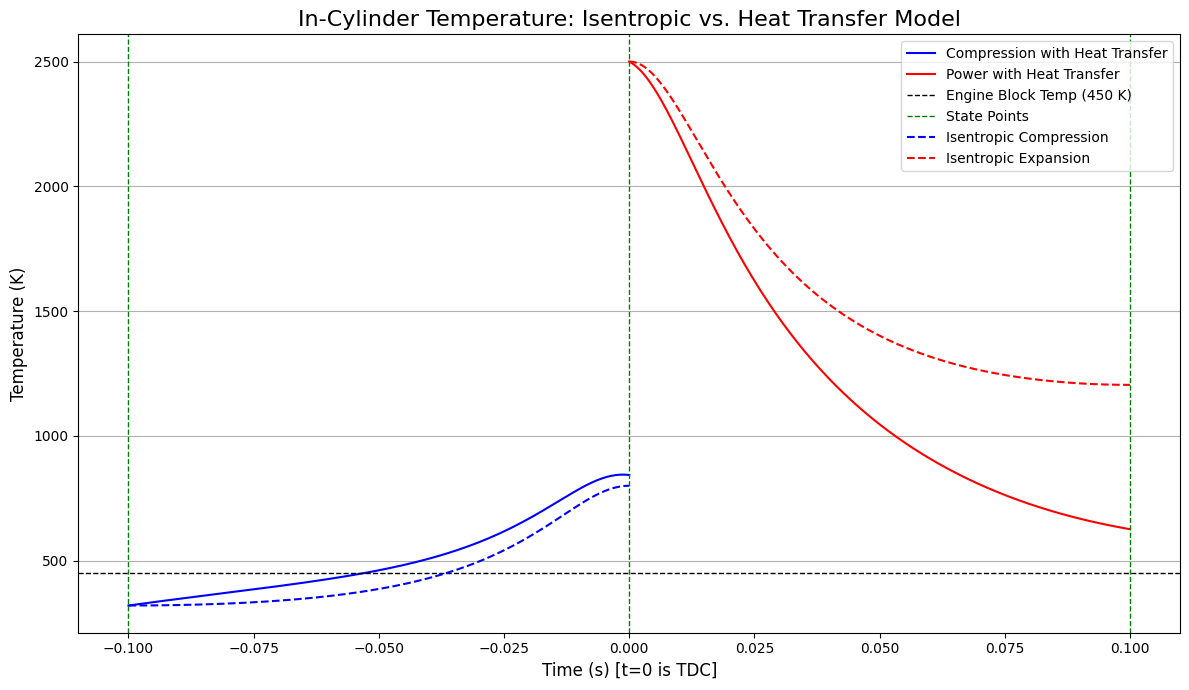

In [31]:
fig1, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(t_plot_comp, T_plot_comp_ht, 'b-', label='Compression with Heat Transfer')
ax1.plot(t_plot_power, T_plot_power_ht, 'r-', label='Power with Heat Transfer')
ax1.axhline(y=T_block, color='black', linestyle='--', linewidth=1, label=f'Engine Block Temp ({T_block} K)')

ax1.axvline(x=t_start_comp, color='green', linestyle='--', linewidth = 1, label='State Points')
ax1.axvline(x=t_end_comp, color='green', linestyle='--', linewidth = 1)
ax1.axvline(x=t_end_power, color='green', linestyle='--', linewidth = 1)


ax1.plot(t_plot_comp, T_plot_comp_isentropic, 'b--', label='Isentropic Compression')
ax1.plot(t_plot_power, T_plot_power_isentropic, 'r--', label='Isentropic Expansion')

ax1.set_title('In-Cylinder Temperature: Isentropic vs. Heat Transfer Model', fontsize=16)
ax1.set_xlabel('Time (s) [t=0 is TDC]', fontsize=12)
ax1.set_ylabel('Temperature (K)', fontsize=12)
ax1.grid(True, axis='y')
ax1.legend()

fig1.tight_layout()

A P-v diagram:

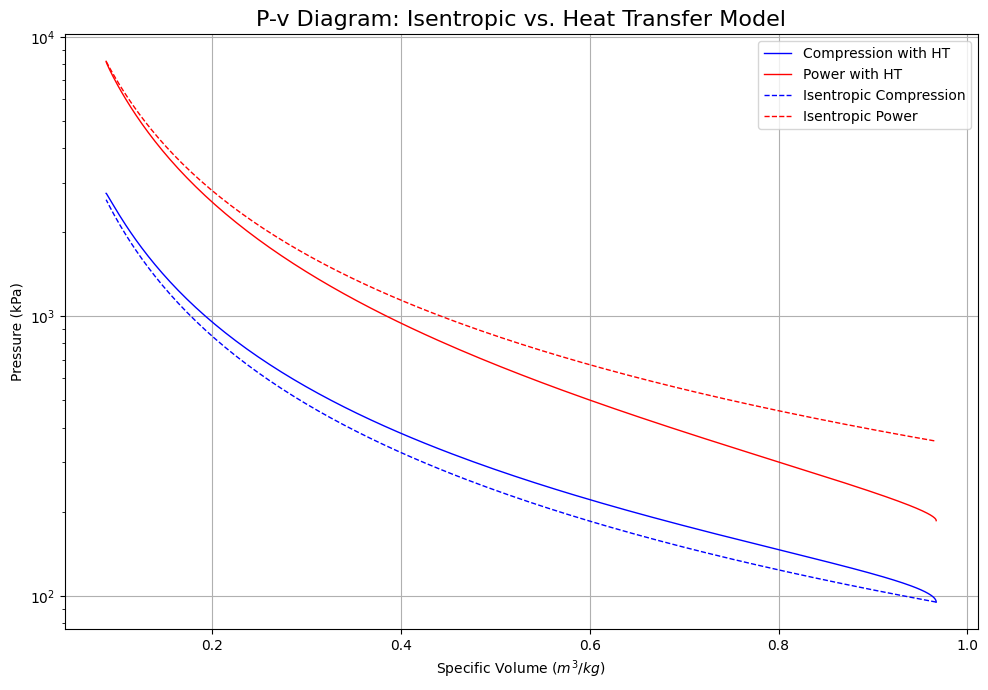

In [32]:
fig2, ax = plt.subplots(figsize=(10,7))

ax.plot(v_spec_comp_curve, P_plot_comp_ht, 'b-', linewidth=1, label='Compression with HT')
ax.plot(v_spec_power_curve, P_plot_power_ht, 'r-', linewidth=1, label='Power with HT')

ax.plot(v_spec_comp_curve, P_plot_comp_isentropic, 'b--', linewidth=1, label='Isentropic Compression')
ax.plot(v_spec_power_curve, P_plot_power_isentropic, 'r--', linewidth=1, label='Isentropic Power')

ax.set_title('P-v Diagram: Isentropic vs. Heat Transfer Model', fontsize=16)
ax.set_xlabel('Specific Volume ($m^3/kg$)')
ax.set_ylabel('Pressure (kPa)')
ax.set_yscale('log')
ax.grid(True)
ax.legend()
fig2.tight_layout()

and a T-v diagram

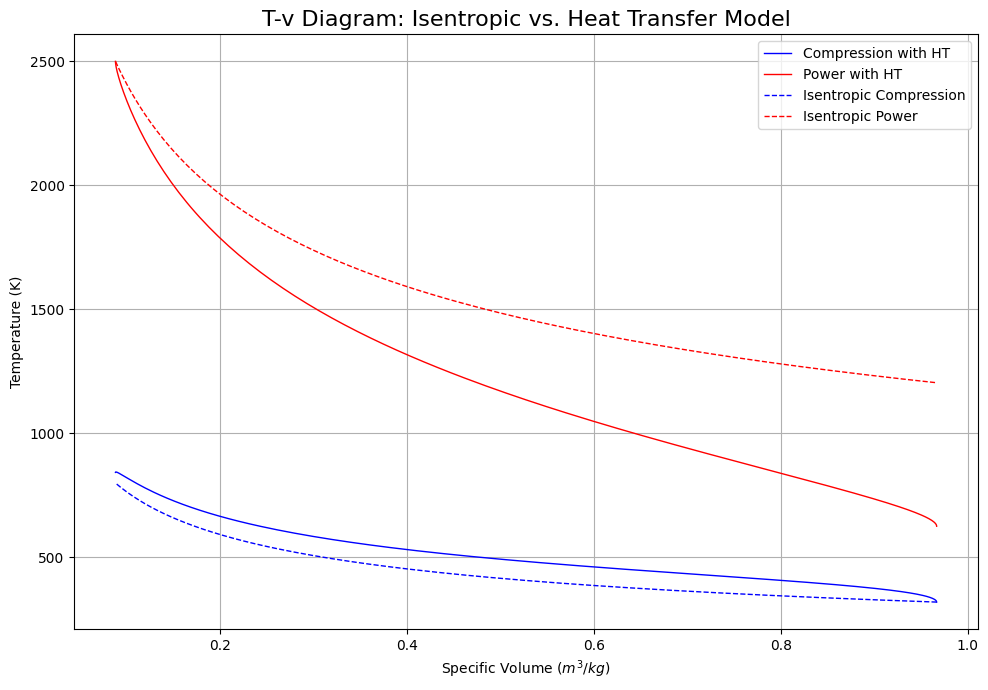

In [33]:
fig3, ax2 = plt.subplots(figsize=(10,7))

ax2.plot(v_spec_comp_curve, T_plot_comp_ht, 'b-', linewidth=1, label='Compression with HT')
ax2.plot(v_spec_power_curve, T_plot_power_ht, 'r-', linewidth=1, label='Power with HT')

ax2.plot(v_spec_comp_curve, T_plot_comp_isentropic, 'b--', linewidth=1, label='Isentropic Compression')
ax2.plot(v_spec_power_curve, T_plot_power_isentropic, 'r--', linewidth=1, label='Isentropic Power')

ax2.set_title('T-v Diagram: Isentropic vs. Heat Transfer Model', fontsize=16)
ax2.set_xlabel('Specific Volume ($m^3/kg$)')
ax2.set_ylabel('Temperature (K)')
ax2.grid(True)
ax2.legend()
fig3.tight_layout()